# IB031 - MBTI

Alžbeta Strompová

## Dataset

Myers-Briggs Type Indicator (MBTI) je osobnostní test navržený pro určení osobnostních typů. Zaměřuje se na to, jak různí lidé vnímají svět a činí svá rozhodnutí.

MBTI rozděluje všechny osoby do 16 různých typů osobnosti rozdělených podle pozice na 4 osách:

* Vnímání okolního prostředí (focus): introverze (**I**ntroversion) – extroverze (**E**xtroversion)
* Získávání informací (information): intuice (i**N**tuition) – smysly (**S**ensing)
* Zpracování informací (decision): myšlení (**T**hinking) – cítění (**F**eeling)
* Životní styl (response): usuzování (**J**udging) – vnímání (**P**erceiving)

### Obsah
Dataset byl vytvořen [Mitchellem Jolly](https://mitchelljolly.com/) na platformě [Kaggle](https://www.kaggle.com/datasets/datasnaek/mbti-type).
Dataset obsahuje 8 675 záznamů, které o člověku říkají:
* Typ (čtyřmístný kód MBTI této osoby.)
* Zhruba 50 posledních příspěvků této osoby. (Každý příspěvek oddělený pomocí "|||" (3 pipe characters))

### Výsledky podobných snažení
Y. Mehta, S. Fatehi, A. Kazameini, C. Stachl, E. Cambria a S. Eetemadi v [Bottom-Up and Top-Down: Predicting Personality with Psycholinguistic and Language Model Features](https://ieeexplore.ieee.org/document/9338428) natrénovali své modely na jiném datasetu a pak to porovnávají na našem. Celkově vyzkoušeli 6 různých modelů. Jejich nejlepší model má výsledky na jednotlivých dimenzích 78.8 %, 86.3 %, 76.1 %, 67.2 %. Jejich celková úspěšnost modelu je **77.1%**. Stejným způsobem budeme meřit i naše modely.

### Rozdělení Datasetu
Jelikož není vhodné trénovat a testovat model na stejném datasetu, rozdělili jsme MBTI dataset na více částí. 

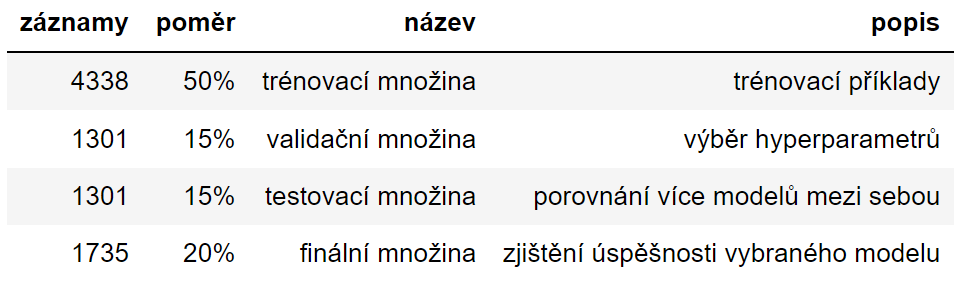

#### Vizualizace

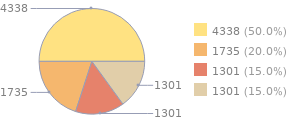

Nastavení prostředi

In [1]:
from matplotlib.pyplot import figure
from seaborn import color_palette
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from typing import Union
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Načtení datasetu

Načteme veškeré soubory... Pro zpracování datasetu byly použiny následující funkce.

Nejzajímavější funkci tvoří split_table, která je použita v baseline modelu a naive bayes.
Rozděluje dataset 16 typů na 4 menší, podle jednotlivých os.

In [2]:
# read train, validation, test or final dataset saved as csv file
def read_table(table: Union['train', 'validation', 'test']):
    return pd.read_csv(f'data/{table}.csv', dtype={'type':'category', 'posts': 'string'})

# get standard names for personality dimensions
# they are based on this infographic https://www.skillsyouneed.com/images/MBTI.png
def get_dimensions():
    return ['focus', 'information', 'decision', 'response']

# separate individual dimensions to four individual tables
def split_table(table):
    dimensions = get_dimensions()
    tables = {}
    new_table = table.apply(lambda row: dict(zip(dimensions, list(row.type))), axis='columns', result_type='expand')
    new_table = new_table.astype(dtype={dimension: 'category' for dimension in dimensions})
    new_table["posts"] = table.posts 
    for dimension in dimensions:
        tables[dimension]=(new_table[[dimension, "posts"]].rename(columns={dimension: "type"}))
    return tables

In [3]:
table = read_table('train')
splitted_tables = split_table(table)
splitted_tables["response"].head(n=3)

,type,posts
0,J,'First of all I just want to say thank you to ...
1,P,'https://www.youtube.com/watch?v=v2H4l9RpkwM&l...
2,P,'That's how Keirsey figures it in his books--t...


## Explorační analýza

Nejdříve si zobrazíme poměr zastoupení jednotlivých typů v datasetu. Z grafu níže je vidět, že introvertní typy mají v datasetu výrazně větší zastoupení.

**Baseline model**, který vrací nejčastější třídu, získá **20% přesnost** 
(accuracy) za předpokladu stejného rozložení dat v trénovací a testovací množině.

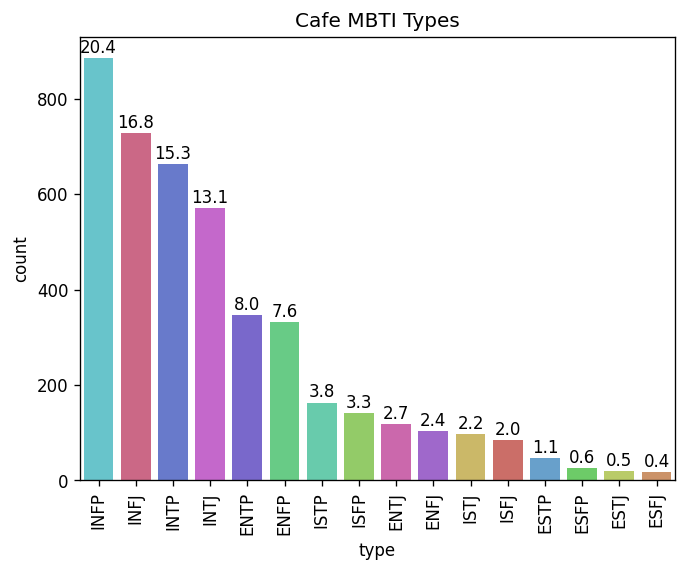

In [4]:
table = read_table('train')
palette = dict(
    zip(
        ["ISFJ","ESFJ","ISTJ","ESTJ","ISFP","ESFP","ENFP","ISTP","INFP","ESTP","INTP","ENTP","ENFJ","INTJ","ENTJ","INFJ"],
        color_palette(palette="hls", n_colors=16).as_hex()
    )
)

figure(dpi=120)
plot = sns.countplot(x=table.type, hue=table.type, order = table.type.value_counts().index, palette=palette)
plot.tick_params(axis='x', rotation=90)
plot.set_title("Cafe MBTI Types")
total = len(table)

for p in plot.patches:
    percentage = f'{100 * p.get_height() / total:.1f}\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plot.annotate(percentage, xy=(x, y), ha='center', va='center')

Následně zobrazíme poměrné zastoupení osobností v rámci všech 4 kategorií. Opět je zde vidět, že v datasetu nejsou jednotlivé skupiny zastoupeny rovnoměrně. 

**Baseline model**, který vrací nejčastější třídu z každé dimenze (osy), získá **77 %, 53 %, 86 %, 60 %** přesnost. Jeho průměrná přesnost je proto **69 %**.



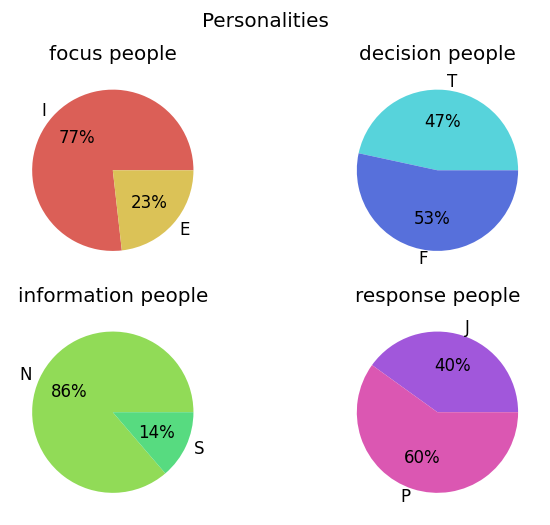

In [5]:
# Describe number of people based on their personalities
def count_posts(table):
    posts = {}
    tables = split_table(table)
    for dimension, table in tables.items():
        first_type = table.head(n=1).type.values[0]
        second_type = table.type[table.type!=first_type].values[0]
        left = len(table.type[table.type==first_type])
        right = len(table.type[table.type==second_type])
        posts[dimension] = (left, right, first_type, second_type)
    return posts

counts = count_posts(table)
fig, axs = plt.subplots(nrows=2, ncols=2)
fig.suptitle("Personalities")
fig.set_dpi(120)
palette = list(color_palette(palette="hls", n_colors=8).as_hex())
for i, (name, (left, right, first_type, second_type)) in enumerate(counts.items()):
    axs[i % 2, i//2].set_title(f"{name} people")
    axs[i % 2, i//2].pie([left, right], labels=[first_type, second_type], colors=[palette[2*i], palette[2*i+1]], autopct='%1.0f%%')

## Modely

### Společné předzpracování

In [6]:
# word2vec, position in a vector space based on word's semantics
# based on fourth seminar
def mean_sentence_word2vec(sentence, analyzer, word_vectors):
    tokens = analyzer(sentence)
    return np.array(
        [word_vectors.get_vector(token) for token in tokens if token in word_vectors]
    ).mean(axis=0)

def embed_sentences(sentences, word_vectors):
    analyzer = CountVectorizer(lowercase=True).build_analyzer()
    return sentences.apply(
        lambda sentence: mean_sentence_word2vec(sentence, analyzer, word_vectors)
)

val = read_table('validation')
train = read_table('train')
test = read_table('test')
final = read_table('final')
word_vectors = api.load("glove-wiki-gigaword-100")

train_vec = np.stack(embed_sentences(train.posts, word_vectors).values)
val_vec = np.stack(embed_sentences(val.posts, word_vectors).values)
test_vec = np.stack(embed_sentences(test.posts, word_vectors).values)
final_vec = np.stack(embed_sentences(final.posts, word_vectors).values)



### BaseLine

Model, který vrací nejčastější hodnotu z datasetu. Pro nás to je třída INFP.
I tento model má průměrnou úspěšnost zhruba 70 %.

In [7]:
def get_result(prediction_labels, true_labels):
    dimensions = [
        100 * sum([x[dim] == y[dim] for x, y in zip(prediction_labels, true_labels)])/true_labels.size
            for dim in range(4)
    ]
    return dimensions, sum(dimensions)/4

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_vec, train.type)

predicted_labels = dummy_clf.predict(test_vec)
true_labels = test.type

print(f'All dimensions guessed correctly: {100*dummy_clf.score(test_vec, test.type):.2f} %')
predictions, average = get_result(predicted_labels, true_labels)
for name, prediction in zip(get_dimensions(), predictions):
    print(f'{name}: {prediction:.2f} %')
print(f'average: {average:.2f} %')


All dimensions guessed correctly: 22.21 %
focus: 78.71 %
information: 85.86 %
decision: 55.88 %
response: 58.80 %
average: 69.81 %


### Random Forest Classifier

Random forest je běžně používaný algoritmus strojového učení navržený Leo Breimanem a Adele Cutler, kombinující výstupy vícera rozhodovacích stromů k dosažení jediného výsledku. Jeho relativně snadné použití a flexibilita podpořily jeho přijetí mezi nejpoužívanější algoritmy pro klasifikaci a regresi.

Algoritmus Random forest se skládá z množství rozhodovacích stromů. Každý strom v souboru se skládá ze vzorku dat získaných z trénovací sady. Z tohoto tréningového vzorku je jedna třetina odložena jako testovací data. Další náhodnosti je následně docíleno pomocí baggingu, což přidává rozmanitost datasetu a snižuje korelace mezi jednotlivými rozhodovacími stromy. Stanovení predikce se následně liší v závislosti na typu problému. U regresní úlohy budou zprůměrovány jednotlivé rozhodovací stromy a u klasifikační úlohy nejčastější kategorická proměnná. Nakonec se vzorek trénovacích dat použije pro křížové ověření.

Klíčovým benefitem Random forest je snížení rizika přetrénování, které hrozí u rozhodovacích stromů. Díky velkému množství rozhodovacích stromů v náhodném lese a snížené varianci dosažené nízkou korelací mezi jednotlivými stromy se model nepřetrénuje.

Pro nalezení nejlepších paremetrů pro RFC byla použita metoda GridSearch. Nejlepších výsledků dosáhly následující kombinace parametrů:

1. {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 300}
2. {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 350}

S těmito parametry byl RFC spuštěn několikrát po sobě a v průměru výsledků se ukázalo, že lepší výsledky vrací druhá možnost, tedy:

- criterion = entropy (funkce využívaná pro určení "kvality" rozdělení)

- max_features = auto (počet parametrů hledaných pro dosažení nejlepšího rozdělení)

- min_samples_leaf = 5 (minimalní počet vzorků na listovém prvků)

- n_estimators = 350 (počet stromů v rozhodovacím lese)

In [8]:
rfc = RandomForestClassifier(n_estimators=350, criterion="gini", min_samples_leaf=5)
rfc.fit(train_vec, train.type)
y_pred = rfc.predict(test_vec)

print(rfc.score(test_vec, test.type))
get_result(y_pred, test.type)

print(f'All dimensions guessed correctly: {100*rfc.score(test_vec, test.type):.2f} %')
predictions, average = get_result(y_pred, test.type)
for name, prediction in zip(get_dimensions(), predictions):
    print(f'{name}: {prediction:.2f} %')
print(f'average: {average:.2f} %')

0.29438893159108376
All dimensions guessed correctly: 29.44 %
focus: 78.86 %
information: 85.86 %
decision: 68.72 %
response: 60.18 %
average: 73.41 %


### Logistic Regression

Tento typ statistické analýzy (také známý jako logit model) se často používá pro prediktivní analýzu a modelování a rozšiřuje se na aplikace ve strojovém učení. V tomto analytickém přístupu je závislá proměnná konečná nebo kategorická: buď A nebo B (binární regrese) nebo řada konečných možností A, B, C nebo D (multinomiální regrese). Používá se ve statistickém softwaru k pochopení vztahu mezi závisle proměnnou a jednou nebo více nezávislými proměnnými pomocí odhadu pravděpodobností pomocí rovnice logistické regrese.

Vyhledávání nejlepších parametrů pro LogisticRegression pomocí Grid Search algoritmu.
Nejlepší výsledek má LogisticRegression s parametry {'C': 10.0, 'class_weight': None, 'max_iter': 2000, 'random_state': 42, 'solver': 'lbfgs'}.

```py
parameters = {
    "random_state": [42],
    'C': [0.01, 0.1, 1, 10.0, 100, 500],
    "class_weight": [None, "balanced"],
    "solver": ["lbfgs", "liblinear", "saga"],
    "max_iter": [800, 1000, 1500, 2000],
}
grid_search = GridSearchCV(LogisticRegression(), parameters, cv=5, verbose=True)
grid_search.fit(train_vec, train.type)

print("Best parameters are:", grid_search.best_params_)
print("Logistic regresion accuracy:", round(grid_search.score(val_vec, val.type) * 100.0, 0), "%")
```

In [9]:
logistic_regression = LogisticRegression(C = 10.0, max_iter = 2000, random_state = 42, solver = 'lbfgs')
logistic_regression.fit(train_vec, train.type)
prediction_log = logistic_regression.predict(test_vec)

predictions, average = get_result(prediction_log, test.type)
print(f'All dimensions guessed correctly: {100*logistic_regression.score(test_vec, test.type):.2f} %')
for name, prediction in zip(get_dimensions(), predictions):
    print(f'{name}: {prediction:.2f} %')
print(f'average: {average:.2f} %')

All dimensions guessed correctly: 35.51 %
focus: 78.25 %
information: 85.93 %
decision: 75.33 %
response: 64.34 %
average: 75.96 %


### Support Vector Machines

Tento model funguje na lineárním principu rozdělování tříd tak, aby vzdálenost od dělící nadroviny k nejbližšímu bodu byla co největší. Základní model je lineární, nicméně může používat kernelový trik, díky kterému dokáže vytvářet nelineární dělící nadroviny.
Představit si to můžeme jako složení papíru tak, aby následně jsme pomocí jedné přímky rozdělili body na papíry na dvě skupiny. I když jsme použili přímku bez zakřivení, tak rozdělení bodů díky zmačkání papíru nebude linearní.
Použitá kernelová funkce vrací výsledek skalárního součinu vektorů, které byly transformovány do komplikovanějšího prostoru, bez výpočtu jejich transformace. Díky tomuto dokáže tento model klasifikovat prostor i nelineárními nadrovinami. Parametrem C se reguluje nesprávná klasifikace tříd, při velkém C hledá klasifikátor nadrovinu, která co nejlépe rozděluje třídy, avšak na úkor vzdálenosti od nejbližších bodů v jednotlivých třídách, u malého C naopak.

Vyhledávání nejlepších parametrů pro SVM pomocí Grid Search algoritmu, přičemž se zkoušejí různé kernelové funkce a parametry C.
Nejlepší výsledek má SVM s parametry C=150 a RBF (Radial Basis Function) kernel.

```py
parameters = {'C': [0.01, 0.1, 1, 10.0, 42.0, 100, 150, 200], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
grid_search = GridSearchCV(SVC(), parameters, cv=5, verbose=True)
grid_search.fit(train_vec, train.type)

print("Best params for SVM classifier model are: ", grid_search.best_params_)
print("SVM classifier with best params accuracy:", round(grid_search.score(val_vec, val.type) * 100.0, 3), "%")
```

In [10]:
clf = SVC(C=150.0, kernel='rbf')
clf.fit(train_vec, train.type)
prediction_svc = clf.predict(test_vec)
predictions, average = get_result(prediction_svc, test.type)
print(f'All dimensions guessed correctly: {100*clf.score(test_vec, test.type):.2f} %')
for name, prediction in zip(get_dimensions(), predictions):
    print(f'{name}: {prediction:.2f} %')
print(f'average: {average:.2f} %')

All dimensions guessed correctly: 34.67 %
focus: 78.48 %
information: 86.24 %
decision: 75.56 %
response: 63.41 %
average: 75.92 %


### Naivní Bayes
Bayes je výkonný model pro detekci spamových zpráv. Možná to bude stejně dobrý
při poznávání osobnostních typů. Pro zvýšení síly modelu jsme natrénovali čtyři
menší modely, jeden pro každou osu osobnosti. Konečný výsledek je pak konstruován 
z těchto jednotlivých predikcí těchto menších modelů. Jako vstup do modelu jsme
vložili jeden dlouhý vektor obsahující pouze počty výskytů slova ve zprávě.

#### Intuitivní popis
V našem datasetu se nachází 77 % introvertů a 23 % extrovertů. To tvoří jakousi
apriorní znalost modelu. Tato pravděpodobnost se někdy zadává manuálně. Dále model
projde všechny věty v trénovací sadě a pro každé slovo si počítá jak pravděpodobné
je, že dané slovo použil introvert nebo extrovert. A to je celé, při testování
se podívá na apriorní znalost, kterou poté upraví pomocí bayesovské věty 
na základě pozorování.

#### Complement Naive Bayes
Ve svém popisu jsem popsal Multinomial Naive Bayes, který měl trošku horší 
úspěšnost, než complement. V čem se liší? Complement počítá pravděpodobnost,
že se hodnota nenachází v zadané množině, čili menší třídy nejsou tak znevýhodněné.


In [11]:
tables = {
    'train': read_table('train'), # learn parameters
    'validation': read_table('validation'), # try hyperparameters
    'test': read_table('test'), # to assess the best model
    'final': read_table('final'), # to get 'real world' values
}

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# learn the dictionary that users of PersonalityCafe use
users_sentences = list(tables['train'].posts.apply(lambda item: item.split("|||")))
training_bundle = [sentence for sentences in users_sentences for sentence in sentences] # flatten
training_bundle[:3]

counter = CountVectorizer(analyzer='word', stop_words="english").fit(
    training_bundle
)

In [13]:
# visualize vectorization of a single sentences, it works as expected. 
# Some words like `do` are skipped, as they do not add much value for the sentence
sentence = "Hello all, do you like any songs? I like all songs! https://youtu.be/dQw4w9WgXcQ"
learned_words = counter.get_feature_names_out()
vectorized_matrix = counter.transform([sentence]).toarray()[0]
print([(z, count) for z, count in zip(learned_words, vectorized_matrix) if count > 0])

[('dqw4w9wgxcq', 1), ('hello', 1), ('https', 1), ('like', 2), ('songs', 2), ('youtu', 1)]


In [14]:
# visualize how many of learned words are actually english words
# takes some time to go through all the 94,743 learned words
# it shows that most words are actually rubbish!
import enchant
d = enchant.Dict("en_US")
english = sum([1 for word in learned_words if d.check(word)])
all = len(learned_words)
print(f'Out of {all} words only {english} ({100*english/all:.2f} %) are actually English words.')

Out of 94743 words only 33782 (35.66 %) are actually English words.


In [15]:
# construct one naive bayes for each personlity dimension
# choose better algorithm from MultinomialNB and ComplementNB
# takes some time to train 8 Naive Bayeses
from sklearn.naive_bayes import MultinomialNB, ComplementNB

def separate_type(table):
    return (table.drop(columns="type"), table.type)

def construct_classifiers(naive_bayes):
    train_tables = split_table(tables['train'])
    classifiers = {}
    
    # construct instance from class for each dimension and train it
    for dimension in get_dimensions():
        classifiers[dimension] = naive_bayes()
        train, labels = separate_type(train_tables[dimension])
        vectorized_train = counter.transform(train.posts).toarray()
        classifiers[dimension].fit(vectorized_train, labels)

    return classifiers

# notice we pass reference to class, not an instance
multinomial = construct_classifiers(MultinomialNB)
complement = construct_classifiers(ComplementNB)

In [16]:
def prediction_result(classifiers, table):
    # vectorize words in table
    vectorized = counter.transform(table.posts).toarray()
    
    # construct from individual dimensions the final prediction
    table["prediction"] = ""
    for dimension in get_dimensions():
        table["prediction"] += classifiers[dimension].predict(vectorized)

    # count all dimensions guessed correctly
    rights = (table.prediction == table.type).sum()

    # count in each dimension separately
    dimensions = {
        dimension: table.apply(lambda row: row.prediction[i]==row.type[i], axis='columns').sum()/len(table) 
                for i, dimension in enumerate(get_dimensions())
    }

    # return all the results
    return {
        'all dimensions guessed correctly': 100*(rights/table.shape[0]),
        'dimensions': dimensions,
        'average accuracy': sum(dimensions.values())/len(dimensions)
    }

print('multinomial', prediction_result(multinomial, tables['validation']))
print('complement', prediction_result(complement, tables['validation']))

multinomial {'all dimensions guessed correctly': 38.50883935434281, 'dimensions': {'focus': 0.754803996925442, 'information': 0.865488086087625, 'decision': 0.8124519600307456, 'response': 0.7255956956187548}, 'average accuracy': 0.7895849346656418}
complement {'all dimensions guessed correctly': 38.73943120676403, 'dimensions': {'focus': 0.7563412759415834, 'information': 0.8647194465795542, 'decision': 0.8101460415065335, 'response': 0.7263643351268255}, 'average accuracy': 0.7893927747886241}


In [17]:
# visualize ComplementNB, which words are the most important?
probs = list(zip(complement['focus'].feature_log_prob_[0], learned_words))
probs.sort()


<BarContainer object of 10 artists>

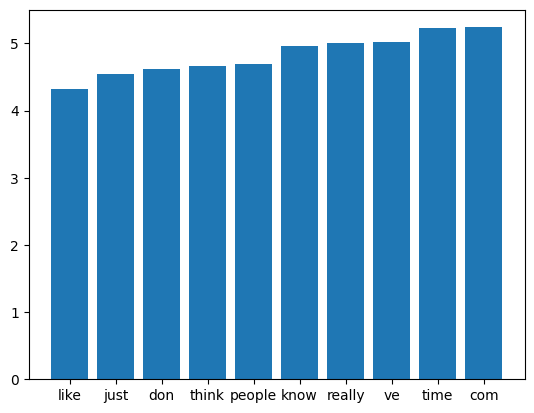

In [18]:
# these words are unimportant
plt.bar(x=list(map(lambda x: x[1], probs[:10])), height=list(map(lambda y: y[0], probs[:10])))


In [19]:
# these words are important...
# Look! some of these are in chinesse, some in unicode fancy fonts and other is just nonsence
# these words are probably one a kind in the dataset - so they describe a person perfectly,
# however they are not much useful for the test set.
probs[-10:]

[(14.50595759641933, '欢迎'),
 (14.50595759641933, '私の馬はきつすぎる私のワニの夜'),
 (14.50595759641933, '０００'),
 (14.50595759641933,
  'ｈｅu3000ｉｓu3000ｔｈｅu3000ｍｏｓｔu3000ｅｓｔｐu3000ｅｓｔｐu3000ｉｎu3000ｔｈｅu3000ｈｉｓｔｏｒｙu3000ｏｆu3000ｅｓｔｐ'),
 (14.50595759641933, 'ｎｅｓｓ'),
 (14.50595759641933, 'ｔｒｕｍｐu3000ｉｓu3000ａｎu3000ｅｓｔｐ'),
 (14.50595759641933, 'ｖａｐｏｒｗａｖｅ'),
 (14.50595759641933,
  'ｗｈｙu3000ｉｓu3000ａｎｙｏｎｅu3000ｓｔｉｌｌu3000ｄｉｓｃｕｓｓｉｎｇu3000ｔｈｉｓ'),
 (14.50595759641933, 'ﾉﾞ'),
 (14.50595759641933, 'ﾉﾟ')]

In [20]:
# in any case, model works quite well
prediction_result(complement, tables['test'])

{'all dimensions guessed correctly': 39.96925441967717,
 'dimensions': {'focus': 0.8001537279016141,
  'information': 0.8593389700230591,
  'decision': 0.8001537279016141,
  'response': 0.708685626441199},
 'average accuracy': 0.7920830130668716}

## Závěr

### Porovnání modelů
Všechny využité modely dosáhly lepší přesnosti než baseline model. Nejlepší průměrné úspěšnosti dosáhl model Naive Bayes. Na druhém místě je potom model Support Vector Machines. 

Model Naive Bayes má lepší výsledky, neboť je lépe stavěný na kratší texty, narozdíl od SVM, které obecně funguje lépe na delších dokumentech, protože hledá vztahy mezi jednotlivými slovy ve větách. Výrazný rozdíl v přesnostech algoritmů je nicméně zajímavý, protože většina zdrojů považuje algoritmy NB a SVM za rovnocenné a většinou záleží pouze na konkrétním datasetu a hyperparametrech.

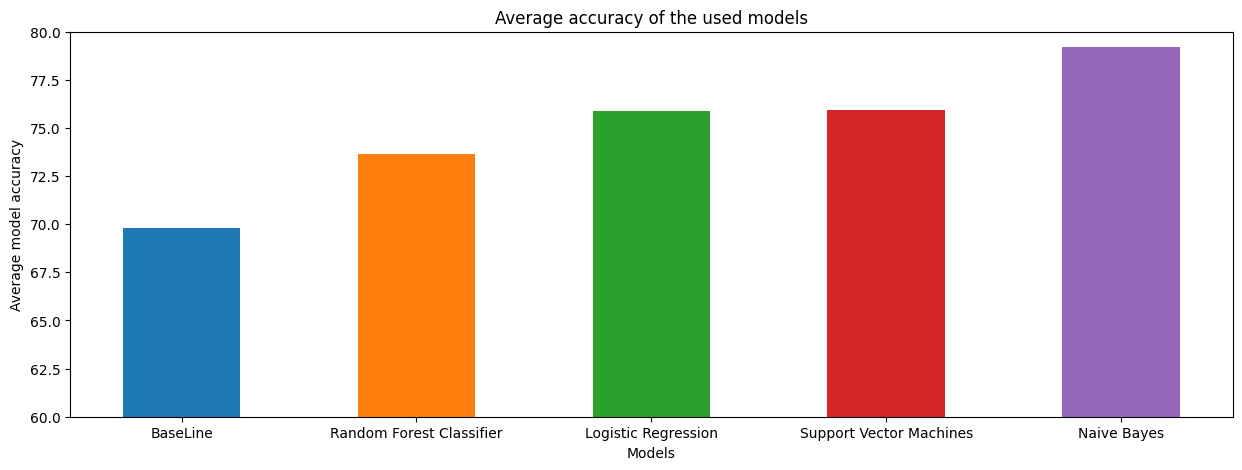

In [21]:
data_dict = {'BaseLine':69.81, 'Random Forest Classifier':73.65, 'Logistic Regression':75.88, 'Support Vector Machines':75.92, 'Naive Bayes':79.21}
courses = list(data_dict.keys())
values = list(data_dict.values())
fig = plt.figure(figsize = (15, 5))
#  Bar plot
plt.bar(courses, values, color = sns.color_palette(),
        width = 0.5)
plt.xlabel("Models")
plt.ylabel("Average model accuracy")
plt.title("Average accuracy of the used models")
plt.ylim(60, 80)
plt.show()

### Předpověď do budoucna
Díky tomu, že jsme si nechali část datasetu úplně na závěr, můžeme zjistit,
jak se náš model bude chovat v praxi. *Final* část datasetu jsme nevyužili
k žádnému rozhodování, pouze k následujícímu testu.

Vybraný model má lepší úspěšnost na této množině, než měl na testovací, 
a zároveň je lepší než článek, který použil neuronové sítě. Avšak i tento 
výsledek musíme brát s rezervou, protože řeč a témata, o kterých se introverti
a extroverti baví, se neustále vyvíjí. 

In [22]:
# Now the final test we've all been waiting for: the final dataset
prediction_result(complement, tables['final'])

{'all dimensions guessed correctly': 40.97982708933718,
 'dimensions': {'focus': 0.7890489913544668,
  'information': 0.8576368876080691,
  'decision': 0.813256484149856,
  'response': 0.7164265129682997},
 'average accuracy': 0.7940922190201728}

In [23]:
{'all dimensions guessed correctly': 40.97982708933718,
 'dimensions': {'focus': 0.7890489913544668,
  'information': 0.8576368876080691,
  'decision': 0.813256484149856,
  'response': 0.7164265129682997},
 'average accuracy': 0.7940922190201728}

{'all dimensions guessed correctly': 40.97982708933718,
 'dimensions': {'focus': 0.7890489913544668,
  'information': 0.8576368876080691,
  'decision': 0.813256484149856,
  'response': 0.7164265129682997},
 'average accuracy': 0.7940922190201728}